## Library & Data

In [1]:
import lightgbm as lgb
import pandas as pd
import re

In [2]:
# 데이터
train = pd.read_csv('movies_train.csv')
test = pd.read_csv('movies_test.csv')
submission = pd.read_csv('submission.csv')

## EDA (탐색적 자료 분석)

In [3]:
train.head(3)

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083


In [4]:
test.head(3)

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7


- title : 영화의 제목
- distributor : 배급사
- genre : 장르
- release_time : 개봉일
- time : 상영시간(분)
- screening_rat : 상영등급
- director : 감독이름
- dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
- dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
- num_staff : 스텝수
- num_actor : 주연배우수
- box_off_num : 관객수

In [5]:
print(train.shape)
print(test.shape)
print(submission.shape)

(600, 12)
(243, 11)
(243, 2)


pd.DataFrame.info()
- 데이터셋의 columns 별 정보를 알려줌

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           243 non-null    object 
 1   distributor     243 non-null    object 
 2   genre           243 non-null    object 
 3   release_time    243 non-null    object 
 4   time            243 non-null    int64  
 5   screening_rat   243 non-null    object 
 6   director        243 non-null    object 
 7   dir_prev_bfnum  107 non-null    float64
 8   dir_prev_num    243 non-null    int64  
 9   num_staff       243 non-null    int64  
 10  num_actor       243 non-null    int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 21.0+ KB


pd.DataFrame.describe()
- 숫자형 columns 들의 기술 통계량을 보여줌

In [8]:
pd.options.display.float_format = '{:.1f}'.format

In [9]:
train.describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.0,270.0,600.0,600.0,600.0,600.0
mean,100.9,1050442.9,0.9,151.1,3.7,708181.8
std,18.1,1791408.3,1.2,165.7,2.4,1828005.9
min,45.0,1.0,0.0,0.0,0.0,1.0
25%,89.0,20380.0,0.0,17.0,2.0,1297.2
50%,100.0,478423.6,0.0,82.5,3.0,12591.0
75%,114.0,1286568.6,2.0,264.0,4.0,479886.8
max,180.0,17615314.0,5.0,869.0,25.0,14262766.0


In [10]:
test.describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
count,243.0,107.0,243.0,243.0,243.0
mean,109.8,891669.5,0.9,159.3,3.5
std,124.0,1217341.5,1.2,163.0,2.1
min,40.0,34.0,0.0,0.0,0.0
25%,91.0,62502.0,0.0,18.0,2.0
50%,104.0,493120.0,0.0,105.0,3.0
75%,114.5,1080849.6,1.0,282.0,4.0
max,2015.0,6173099.5,6.0,776.0,16.0


pd.DataFrame.groupby()
- 그룹 별 통계량 확인

In [11]:
train[['genre', 'box_off_num']].groupby('genre').mean().sort_values('box_off_num')

,box_off_num
genre,
뮤지컬,6627.0
다큐멘터리,67172.3
서스펜스,82611.0
애니메이션,181926.7
멜로/로맨스,425968.0
미스터리,527548.2
공포,590832.5
드라마,625689.8
코미디,1193914.0


pd.DataFrame.corr()
- 컬럼들 간 상호 연관성
- 보통 0.4 이상이면 두 개의 변수간에 상관성이 있다고 본다

In [12]:
pd.reset_option('display.float_format')

In [13]:
train.corr()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
time,1.000000,0.264675,0.306727,0.623205,0.114153,0.441452
dir_prev_bfnum,0.264675,1.000000,0.131822,0.323521,0.083818,0.283184
dir_prev_num,0.306727,0.131822,1.000000,0.450706,0.014006,0.259674
num_staff,0.623205,0.323521,0.450706,1.000000,0.077871,0.544265
num_actor,0.114153,0.083818,0.014006,0.077871,1.000000,0.111179
box_off_num,0.441452,0.283184,0.259674,0.544265,0.111179,1.000000


<AxesSubplot: >

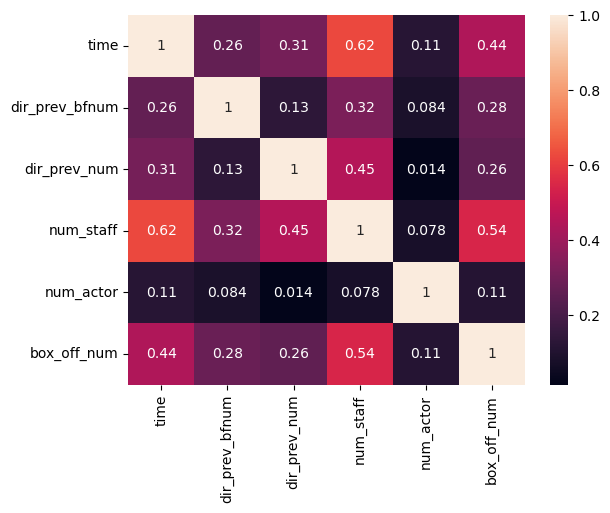

In [14]:
import seaborn as sns
sns.heatmap(train.corr(), annot=True)

## Data Cleansing & Pre-Processing

pd.Series.isna()
- 결측치 여부 확인

In [15]:
train.isna().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

In [16]:
test.isna().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dtype: int64

In [17]:
train['dir_prev_bfnum'].fillna(0, inplace=True)
test['dir_prev_bfnum'].fillna(0, inplace=True)

In [18]:
train.isna().sum()

title             0
distributor       0
genre             0
release_time      0
time              0
screening_rat     0
director          0
dir_prev_bfnum    0
dir_prev_num      0
num_staff         0
num_actor         0
box_off_num       0
dtype: int64

In [19]:
test.isna().sum()

title             0
distributor       0
genre             0
release_time      0
time              0
screening_rat     0
director          0
dir_prev_bfnum    0
dir_prev_num      0
num_staff         0
num_actor         0
dtype: int64

In [20]:
train

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,0.00,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387
...,...,...,...,...,...,...,...,...,...,...,...,...
595,해무,(주)NEW,드라마,2014-08-13,111,청소년 관람불가,심성보,3833.00,1,510,7,1475091
596,파파로티,(주)쇼박스,드라마,2013-03-14,127,15세 관람가,윤종찬,496061.00,1,286,6,1716438
597,살인의 강,(주)마운틴픽쳐스,공포,2010-09-30,99,청소년 관람불가,김대현,0.00,0,123,4,2475
598,악의 연대기,CJ 엔터테인먼트,느와르,2015-05-14,102,15세 관람가,백운학,0.00,0,431,4,2192525


### 배급사 전처리

In [21]:
len(train['distributor'].unique())

169

In [22]:
train['distributor'].value_counts()

CJ 엔터테인먼트        54
롯데엔터테인먼트         52
(주)NEW           30
(주)마운틴픽쳐스        29
(주)쇼박스           26
                 ..
OAL(올)            1
(주)에이원 엔터테인먼트     1
(주)콘텐츠 윙          1
위더스필름             1
퍼스트런              1
Name: distributor, Length: 169, dtype: int64

In [23]:
# (주) 제거
train['distributor'] = train.distributor.str.replace("(주)", '')
test['distributor'] = test.distributor.str.replace("(주)", '')

C:\Users\us\AppData\Local\Temp\ipykernel_15980\1690730502.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train['distributor'] = train.distributor.str.replace("(주)", '')
C:\Users\us\AppData\Local\Temp\ipykernel_15980\1690730502.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test['distributor'] = test.distributor.str.replace("(주)", '')


In [24]:
# 정규표현식 사용해서 숫자, 문자, 한글 제외하고 삭제
train['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in train.distributor]
test['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in test.distributor]

In [25]:
# 배급사명 통일을 위한 함수
def get_dis(x) :
    if 'CJ' in x or 'CGV' in x :
        return 'CJ'
    elif '쇼박스' in x :
        return '쇼박스'
    elif 'SK' in x :
        return 'SK'
    elif '리틀빅픽' in x :
        return '리틀빅픽처스'
    elif '스폰지' in x :
        return '스폰지'
    elif '싸이더스' in x :
        return '싸이더스'
    elif '에이원' in x :
        return '에이원'
    elif '마인스' in x :
        return '마인스'
    elif '마운틴픽' in x :
        return '마운틴픽처스'
    elif '디씨드' in x :
        return '디씨드'
    elif '드림팩트' in x :
        return '드림팩트'
    elif '메가박스' in x :
        return '메가박스'
    elif '마운틴' in x :
        return '마운틴'
    else :
        return x

In [26]:
train['distributor'] = train.distributor.apply(get_dis)
test['distributor'] = test.distributor.apply(get_dis)

In [27]:
len(train['distributor'].unique())

147

In [28]:
train['distributor'].value_counts()

CJ          68
롯데엔터테인먼트    52
NEW         38
마운틴픽처스      33
쇼박스         28
            ..
OAL올         1
위더스필름        1
콘텐츠윙         1
팝파트너스        1
퍼스트런         1
Name: distributor, Length: 147, dtype: int64

### 장르별 영화 관객수 평균값으로 랭크 인코딩

In [29]:
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,0.00,0,91,2,23398
1,내부자들,쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


In [30]:
train['genre'].value_counts()

드라마       221
다큐멘터리      93
멜로/로맨스     78
코미디        53
공포         42
액션         28
느와르        27
애니메이션      21
미스터리       17
SF         13
뮤지컬         5
서스펜스        2
Name: genre, dtype: int64

In [31]:
# 영화관객수 평균 순으로 나열
train.groupby('genre').box_off_num.mean().sort_values()

genre
뮤지컬       6.627000e+03
다큐멘터리     6.717226e+04
서스펜스      8.261100e+04
애니메이션     1.819267e+05
멜로/로맨스    4.259680e+05
미스터리      5.275482e+05
공포        5.908325e+05
드라마       6.256898e+05
코미디       1.193914e+06
SF        1.788346e+06
액션        2.203974e+06
느와르       2.263695e+06
Name: box_off_num, dtype: float64

In [32]:
# 하드인코딩
train['genre_rank'] = train.genre.map({'뮤지컬' : 1, '다큐멘터리' : 2, '서스펜스' : 3, '애니메이션' : 4, '멜로/로맨스' : 5,
                                      '미스터리' : 6, '공포' : 7, '드라마' : 8, '코미디' : 9, 'SF' : 10, '액션' : 11, '느와르' : 12})
test['genre_rank'] = test.genre.map({'뮤지컬' : 1, '다큐멘터리' : 2, '서스펜스' : 3, '애니메이션' : 4, '멜로/로맨스' : 5,
                                      '미스터리' : 6, '공포' : 7, '드라마' : 8, '코미디' : 9, 'SF' : 10, '액션' : 11, '느와르' : 12})

In [33]:
train.head(3)

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,genre_rank
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,0.00,0,91,2,23398,11
1,내부자들,쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501,12
2,은밀하게 위대하게,쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083,11


### 배급사별 영화 관객수 중위값 기준 배급사 랭크 인코딩

In [34]:
tr_nm_rank = train.groupby('distributor').box_off_num.median().reset_index(name='num_rank').sort_values(by='num_rank')

In [35]:
tr_nm_rank

,distributor,num_rank
110,인피니티엔터테인먼트,2.0
15,고구마공작소,8.0
52,사람과사람들,42.0
97,위드시네마,46.0
19,나우콘텐츠,54.0
...,...,...
113,전망좋은영화사,1214237.0
105,이십세기폭스코리아,1422844.0
56,쇼박스,2138560.0
84,영구아트무비,2541603.0


In [36]:
tr_nm_rank.shape

(147, 2)

In [37]:
tr_nm_rank['num_rank'] = [i + 1 for i in range(tr_nm_rank.shape[0])]

In [38]:
tr_nm_rank

,distributor,num_rank
110,인피니티엔터테인먼트,1
15,고구마공작소,2
52,사람과사람들,3
97,위드시네마,4
19,나우콘텐츠,5
...,...,...
113,전망좋은영화사,143
105,이십세기폭스코리아,144
56,쇼박스,145
84,영구아트무비,146


데이터 병합

In [39]:
train = pd.merge(train, tr_nm_rank, how = 'left')
test = pd.merge(test, tr_nm_rank, how = 'left')

In [40]:
train.head(3)

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,genre_rank,num_rank
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,0.00,0,91,2,23398,11,134
1,내부자들,쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501,12,145
2,은밀하게 위대하게,쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083,11,145


In [41]:
test.head(3)

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,genre_rank,num_rank
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3,12,132.0
1,아빠가 여자를 좋아해,쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3,5,145.0
2,하모니,CJ,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7,8,141.0


### 날짜

In [42]:
train['release_time'] = pd.to_datetime(train['release_time'])
train['release_year'] = train['release_time'].dt.year
train['release_month'] = train['release_time'].dt.month

test['release_time'] = pd.to_datetime(test['release_time'])
test['release_year'] = test['release_time'].dt.year
test['release_month'] = test['release_time'].dt.month

In [43]:
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,genre_rank,num_rank,release_year,release_month
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,0.00,0,91,2,23398,11,134,2012,11
1,내부자들,쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501,12,145,2015,11
2,은밀하게 위대하게,쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083,11,145,2013,6
3,나는 공무원이다,NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866,9,140,2012,7
4,불량남녀,쇼박스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387,9,145,2010,11


In [59]:
test.fillna(0, inplace = True)

# 모델링
- 타겟 값인 관객수를 로그 변환
- 상영등급 더미 변수
- 출연 배우 수도 로그변환

In [60]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from ngboost import NGBRegressor
import numpy as np

In [61]:
X = train[['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor', 'genre_rank', 'num_rank',
           'release_year', 'release_month', 'screening_rat']]
y = np.log1p(train.box_off_num)

In [62]:
X = pd.get_dummies(columns = ['screening_rat'], data = X)

In [63]:
X['num_actor'] = np.log1p(X['num_actor'])

In [64]:
target = test[['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor', 'genre_rank', 'num_rank',
           'release_year', 'release_month', 'screening_rat']]

In [65]:
target = pd.get_dummies(columns = ['screening_rat'], data = target)

In [66]:
target['num_actor'] = np.log1p(target['num_actor'])

## 10Fold 교차검증

In [67]:
kf = KFold(n_splits = 10, shuffle = True, random_state = 42)

## 5가지 모델 사용
1) GradientBoostingRegressor

In [68]:
train.isna().sum()

title             0
distributor       0
genre             0
release_time      0
time              0
screening_rat     0
director          0
dir_prev_bfnum    0
dir_prev_num      0
num_staff         0
num_actor         0
box_off_num       0
genre_rank        0
num_rank          0
release_year      0
release_month     0
dtype: int64

In [69]:
test.isna().sum()

title             0
distributor       0
genre             0
release_time      0
time              0
screening_rat     0
director          0
dir_prev_bfnum    0
dir_prev_num      0
num_staff         0
num_actor         0
genre_rank        0
num_rank          0
release_year      0
release_month     0
dtype: int64

In [70]:
gbm = GradientBoostingRegressor(random_state = 42)

In [71]:
rmse_list = []
gb_pred = np.zeros((test.shape[0]))
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    gbm.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in gbm.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in gbm.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    gb_pred += (sub_pred / 10)

In [72]:
np.mean(rmse_list)

1026415.4785540076

2) NGBRegressor

In [73]:
ngb = NGBRegressor(random_state = 518)

In [74]:
rmse_list = []
ngb_pred = np.zeros((test.shape[0]))
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    ngb.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in ngb.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in ngb.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    ngb_pred += (sub_pred / 10)

[iter 0] loss=2.6200 val_loss=0.0000 scale=1.0000 norm=2.9523
[iter 100] loss=1.9869 val_loss=0.0000 scale=2.0000 norm=2.7824
[iter 200] loss=1.5843 val_loss=0.0000 scale=2.0000 norm=2.1721
[iter 300] loss=1.4440 val_loss=0.0000 scale=2.0000 norm=2.0736
[iter 400] loss=1.3503 val_loss=0.0000 scale=1.0000 norm=0.9998
[iter 0] loss=1.3876 val_loss=0.0000 scale=1.0000 norm=1.0614
[iter 100] loss=1.2902 val_loss=0.0000 scale=1.0000 norm=0.9785
[iter 200] loss=1.2425 val_loss=0.0000 scale=1.0000 norm=0.9515
[iter 300] loss=1.2012 val_loss=0.0000 scale=1.0000 norm=0.9311
[iter 400] loss=1.1642 val_loss=0.0000 scale=0.5000 norm=0.4560
[iter 0] loss=1.1702 val_loss=0.0000 scale=0.5000 norm=0.4647
[iter 100] loss=1.1220 val_loss=0.0000 scale=0.2500 norm=0.2240
[iter 200] loss=1.0949 val_loss=0.0000 scale=1.0000 norm=0.8800
[iter 300] loss=1.0737 val_loss=0.0000 scale=1.0000 norm=0.8662
[iter 400] loss=1.0448 val_loss=0.0000 scale=0.5000 norm=0.4255
[iter 0] loss=1.0570 val_loss=0.0000 scale=1.0

In [75]:
np.mean(rmse_list)

1499629.3504939775

3) LGBMRegressor

In [76]:
lgbm = LGBMRegressor(random_state = 518)

In [77]:
rmse_list = []
lgb_pred = np.zeros((test.shape[0]))
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    lgbm.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in lgbm.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in lgbm.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    lgb_pred += (sub_pred / 10)

In [78]:
np.mean(rmse_list)


1167233.8668575704

4) XGBRegressor

In [79]:
xgb = XGBRegressor(random_state = 518)

In [80]:
rmse_list = []
xgb_pred = np.zeros((test.shape[0]))
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    xgb.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in xgb.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in xgb.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    xgb_pred += (sub_pred / 10)

In [81]:
np.mean(rmse_list)

1119274.0007823491

5) CatBoostRegressor

In [82]:
cat = CatBoostRegressor(random_state = 518, silent = True)

In [83]:
rmse_list = []
cat_pred = np.zeros((test.shape[0]))
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    cat.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in cat.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in cat.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    cat_pred += (sub_pred / 10)

In [84]:
np.mean(rmse_list)

1074036.6761615244

6) RandomForestRegressor

In [85]:
rf = RandomForestRegressor(random_state = 518)

In [86]:
rmse_list = []
rf_pred = np.zeros((test.shape[0]))
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    rf.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in rf.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in rf.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    rf_pred += (sub_pred / 10)

In [87]:
np.mean(rmse_list)

864351.6401903124

예측결과 섞기

In [88]:
submission['box_off_num'] = (xgb_pred + cat_pred + lgb_pred + rf_pred + gb_pred + ngb_pred) / 6

In [89]:
submission.sort_values(by = 'box_off_num')

,title,box_off_num
130,댄서김의 은밀한 교수법,1.901705e+01
39,REC 알이씨,2.106036e+01
173,옹녀뎐,2.457928e+01
7,이웃집 남자,2.699881e+01
65,엄마는 창녀다,3.097218e+01
...,...,...
81,내가 살인범이다,3.619733e+06
135,용의자,4.597649e+06
142,박수건달,4.829328e+06
179,군도: 민란의 시대,6.639722e+06


In [90]:
submission.to_csv("0520.csv", index = False)